When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [36]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")

In [37]:
info = systeminfo()
user = info["user"]
node = info["uname.node"]
processors = 4

In [38]:
p = widgets.IntSlider(
    value=processors,
    min=2,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=4, continuous_update=False, description='Processors:', max=64, min=2)

Text(value='green', description='User:', placeholder='The user name')

Text(value='earth', description='Computer:', placeholder='The computer name')

In [39]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

8 gregor i5


In [40]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [41]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[8, 1280000, 2560000, 3840000, 5120000, 6400000, 7680000, 8960000, 10240000, 11520000]


In [42]:
os.makedirs(output, exist_ok=True)

In [43]:
systeminfo = StopWatch.systeminfo()
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [44]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [45]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 8                    10 | 0/10 [00:00<?, ?it/s]

Benchmark 1280000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2560000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 3840000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 6400000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 7680000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 8960000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 11520000             10 | 0/10 [00:00<?, ?it/s]

In [46]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
8,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1280000,1.544,1.522,1.538,1.539,1.528,1.479,1.474,1.531,1.454,1.447
2560000,2.892,2.887,2.991,2.929,3.000,2.918,2.907,2.895,2.909,2.971
3840000,4.352,4.352,4.376,4.366,4.334,4.308,4.322,4.338,4.419,4.354
5120000,5.820,5.830,5.831,5.777,5.868,6.037,5.783,5.894,5.879,5.850
6400000,7.594,7.428,7.311,7.354,7.302,7.402,7.205,7.385,7.243,7.319
7680000,8.681,8.664,8.956,8.789,8.784,8.958,8.691,8.719,8.655,8.703
8960000,10.219,10.143,10.359,10.201,10.322,10.015,10.208,10.183,10.134,10.341
10240000,11.727,11.869,11.831,11.804,11.689,11.603,11.691,11.745,11.586,11.655


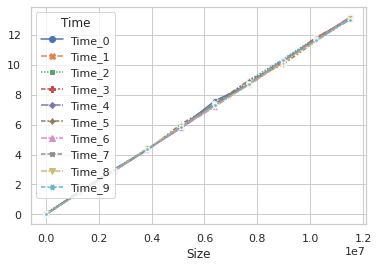

In [47]:
sns.lineplot(data=df, markers=True);

In [48]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [49]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
8,0.000
8,0.000
8,0.087
8,0.000
8,0.000
...,...
11520000,13.157
11520000,13.210
11520000,13.146


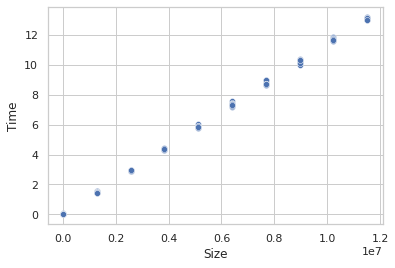

In [50]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

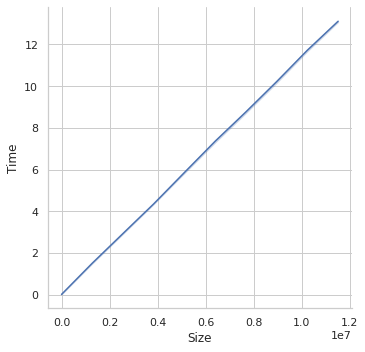

In [51]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [52]:
df.to_pickle(f"{output}/{label}-df.pkl")